<a href="https://colab.research.google.com/github/MarrinXia/MSSP-607/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (12411, 45)
Columns (前20): ['COD_S11', 'GENDER', 'EDU_FATHER', 'EDU_MOTHER', 'OCC_FATHER', 'OCC_MOTHER', 'STRATUM', 'SISBEN', 'PEOPLE_HOUSE', 'INTERNET', 'TV', 'COMPUTER', 'WASHING_MCH', 'MIC_OVEN', 'CAR', 'DVD', 'FRESH', 'PHONE', 'MOBILE', 'REVENUE']
            COD_S11 GENDER                         EDU_FATHER  \
0  SB11201210000129      F  Incomplete Professional Education   
1  SB11201210000137      F                 Complete Secundary   
2  SB11201210005154      M                           Not sure   

                         EDU_MOTHER                                OCC_FATHER  \
0  Complete technique or technology  Technical or professional level employee   
1   Complete professional education                             Entrepreneur    
2                          Not sure                               Independent   

                 OCC_MOTHE

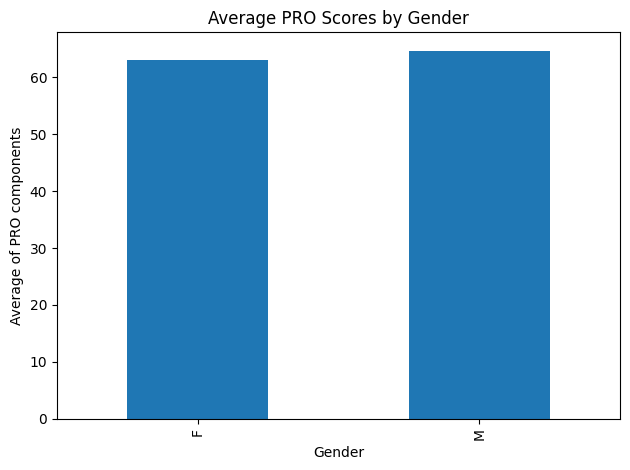

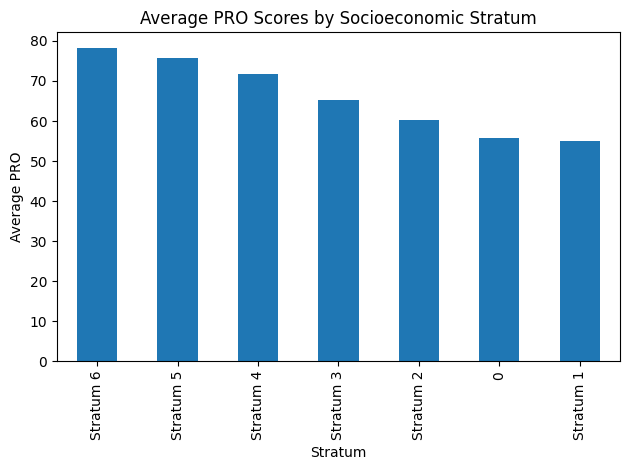

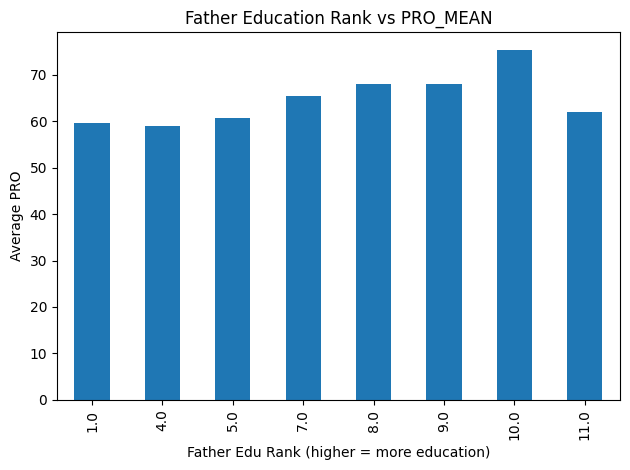

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# 1)import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 2) 路径设置
DATA_PATH = "/content/drive/MyDrive/MSSP607/data/data_academic_performance.xlsx"
SHEET_NAME = "SABER11_SABERPRO"   # 主数据工作表名

# 3) 读入数据（Excel有多个sheet）
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

# 4) 轻清洗：删除“Unnamed”空列；标准化列名（空格→下划线，大写）
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed")]
df.columns = [c.strip().replace(" ", "_").upper() for c in df.columns]

# 5) 构造综合指标：高教统一考试（PRO）五个分项的平均 PRO_MEAN
PRO_COLS = ["QR_PRO","CR_PRO","CC_PRO","ENG_PRO","WC_PRO"]
for c in PRO_COLS:
    # 有些列可能是字符串或有缺失，尝试转数值
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["PRO_MEAN"] = df[PRO_COLS].mean(axis=1)

# 6) 快速查看基础信息
print("Shape:", df.shape)
print("Columns (前20):", df.columns.tolist()[:20])
print(df.head(3))

# 7) —— 分组汇总（性别 / 分层 STRATUM）——
NUM_COLS_S11 = ["MAT_S11","CR_S11","CC_S11","BIO_S11","ENG_S11"]
NUM_COLS_PRO = PRO_COLS
NUM_COLS = NUM_COLS_S11 + NUM_COLS_PRO + ["PRO_MEAN"]

# 7.1 按性别
summary_by_gender = (
    df.groupby("GENDER")[NUM_COLS]
      .agg(["mean","std","count"])
)
print("\n[Summary by Gender] (预览):")
print(summary_by_gender.head(10))

# 7.2 按社会经济分层 STRATUM
summary_by_stratum = (
    df.groupby("STRATUM")[NUM_COLS]
      .agg(["mean","std","count"])
)
print("\n[Summary by STRATUM] (预览):")
print(summary_by_stratum.head(10))

# 8) —— 父母教育与成绩 ——（有序映射 + 相关）
edu_order = [
    "No schooling", "Ninguno",                        # 无学业
    "Incomplete Primary", "Complete Primary",         # 小学
    "Incomplete Secundary", "Complete Secundary",     # 中学
    "Incomplete technique or technology", "Complete technique or technology",   # 技专
    "Incomplete Professional Education", "Complete professional education",     # 本科
    "Postgraduate education",                         # 研究生
    "Not sure"                                        # 不确定（放最后，通常不参与有序分析）
]
edu_rank = {k:i for i,k in enumerate(edu_order)}

# 映射父/母教育到“等级分”（无匹配的会是NaN）
for col, newcol in [("EDU_FATHER","EDU_F_RANK"), ("EDU_MOTHER","EDU_M_RANK")]:
    if col in df.columns:
        df[newcol] = df[col].map(edu_rank)
    else:
        df[newcol] = np.nan

        # 与各分项及PRO_MEAN的相关（皮尔逊）
corr_parent = (
    df[["EDU_F_RANK","EDU_M_RANK"] + PRO_COLS + ["PRO_MEAN"]]
      .corr()
      .loc[["EDU_F_RANK","EDU_M_RANK"]]
      .round(3)
)
print("\n[父母教育等级 与 PRO 分项/均值 相关]：")
print(corr_parent)

# 9) —— 简洁图表 Matplotlib：每个图单独一张；不指定颜色——
# 9.1 性别 vs PRO_MEAN
plt.figure()
df.groupby("GENDER")["PRO_MEAN"].mean().plot(kind="bar", title="Average PRO Scores by Gender")
plt.xlabel("Gender"); plt.ylabel("Average of PRO components")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MSSP607/fig_pro_mean_by_gender.png", dpi=150)

# 9.2 STRATUM vs PRO_MEAN
plt.figure()
df.groupby("STRATUM")["PRO_MEAN"].mean().sort_values(ascending=False).plot(
    kind="bar", title="Average PRO Scores by Socioeconomic Stratum"
)
plt.xlabel("Stratum"); plt.ylabel("Average PRO")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MSSP607/fig_pro_mean_by_stratum.png", dpi=150)

# 9.3 父亲教育等级 vs PRO_MEAN（也可以换成母亲教育等级）
plt.figure()
(
    df.groupby("EDU_F_RANK")["PRO_MEAN"]
      .mean()
      .sort_index()
      .plot(kind="bar", title="Father Education Rank vs PRO_MEAN")
)
plt.xlabel("Father Edu Rank (higher = more education)")
plt.ylabel("Average PRO")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MSSP607/fig_pro_mean_vs_father_rank.png", dpi=150)

print("\n图已保存到 /MyDrive/MSSP607/：fig_pro_mean_by_gender.png, fig_pro_mean_by_stratum.png, fig_pro_mean_vs_father_rank.png")

# 10) —— 导出结果到CSV（用于报告附录/插图引用）——
summary_by_gender.to_csv("/content/drive/MyDrive/MSSP607/summary_by_gender.csv")
summary_by_stratum.to_csv("/content/drive/MyDrive/MSSP607/summary_by_stratum.csv")
# 父母教育两两组合的均值（便于写作时举例）
summary_by_parent_combo = (
    df.groupby(["EDU_FATHER","EDU_MOTHER"])["PRO_MEAN"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)
summary_by_parent_combo.to_csv("/content/drive/MyDrive/MSSP607/summary_by_parent_edu_combo.csv", index=False)
corr_parent.to_csv("/content/drive/MyDrive/MSSP607/corr_parent_outcomes.csv")

print("\nCSV 已导出：summary_by_gender/stratum/parent_edu_combo/corr_parent_outcomes")

# 11) ——（最后考虑这个，可用可不用）简单显著性检验 ——
# 性别t检验；STRATUM 单因素方差（若需要可以开启）
# 注意：正式报告请配合稳健标准误、事后比较或多重检验说明。

RUN_TESTS = False
if RUN_TESTS:
    from scipy import stats
    # t-test: 男 vs 女 的 PRO_MEAN
    m = df.loc[df["GENDER"]=="M","PRO_MEAN"].dropna()
    f = df.loc[df["GENDER"]=="F","PRO_MEAN"].dropna()
    tstat, pval = stats.ttest_ind(m, f, equal_var=False)  # Welch
    print(f"\nGender t-test (Welch): t={tstat:.3f}, p={pval:.4f}")

    # ANOVA: STRATUM 组间差异
    groups = [g["PRO_MEAN"].dropna().values for _, g in df.groupby("STRATUM")]
    F, p = stats.f_oneway(*groups)
    print(f"STRATUM ANOVA: F={F:.3f}, p={p:.4f}")

# 12) 最小复查（在报告里引用的关键数字）
gender_means = df.groupby("GENDER")["PRO_MEAN"].mean().round(2)
stratum_means = df.groupby("STRATUM")["PRO_MEAN"].mean().round(2).sort_values(ascending=False)
print("\n[PRO_MEAN — Gender 均值]：\n", gender_means)
print("\n[PRO_MEAN — STRATUM 均值Rank]：\n", stratum_means)